# Random Forest Regression - Real Estate Absolute Price Prediction

This notebook builds a Random Forest regression model to predict absolute property prices (price_converted) using the processed alonhadat dataset. Random Forest is an ensemble learning method that combines multiple decision trees to improve prediction accuracy and control overfitting.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## 2. Load Data

In [2]:
# Load the preprocessed data
df = pd.read_csv('../../Data Preprocessing/alonhadat_processed.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (14426, 17)

First few rows:


,address,area,bedrooms,date,floors,price,title,road,ward,district,address_complete,road_cat,ward_cat,district_cat,price_converted,is_price_per_m2,price_per_m2
0,"Đường Nguyễn Văn Cừ, Phường Gia Thụy, Quận Lon...",80,1,Hôm nay,1,"7,5 tỷ","🥇ĐẤT NGUYỄN VĂN CỪ 80M, MT8M, MẢNH ĐẤT RỘNG TH...",Nguyễn Văn Cừ,Gia Thụy,Long Biên,1,564,54,11,7500.00,False,93.75
1,"Đường Ngọc Lâm, Phường Ngọc Lâm, Quận Long Biê...",36,3,Hôm nay,6,"8,65 tỷ","🔥CÒN DUY NHẤT 1 CĂN GIÁ RẺ, NGỌC LÂM 36M, 6T G...",Ngọc Lâm,Ngọc Lâm,Long Biên,1,603,157,11,8650.00,False,240.28
2,"Đường Ngô Gia Tự, Phường Đức Giang, Quận Long ...",56,1,Hôm nay,1,"15,5 tỷ","👉MẶT PHỐ, NGÔ GIA TỰ, 56M, MT4M, VỈA HÈ ĐÁ BÓN...",Ngô Gia Tự,Đức Giang,Long Biên,1,587,390,11,15500.00,False,276.79
3,"Đường Phúc Lợi, Phường Phúc Lợi, Quận Long Biê...",32,3,Hôm nay,5,"5,2 tỷ","🥇CĂN DUY NHẤT, NGÕ THÔNG, Ô TÔ , LÔ GÓC, PHÚC ...",Phúc Lợi,Phúc Lợi,Long Biên,1,667,193,11,5200.00,False,162.50
4,"Phố Lệ Mật, Phường Việt Hưng, Quận Long Biên, ...",58,3,Hôm nay,3,7 tỷ,"🏡VIỆT HƯNG, DIỆN TÍCH RỘNG 58m, 3T, MT5m GIÁ C...",Lệ Mật,Việt Hưng,Long Biên,1,445,313,11,7000.00,False,120.69


In [3]:
# Check data types and missing values
print("\nData types and missing values:")
df.info()

# Display descriptive statistics for numeric columns
print("\nDescriptive statistics:")
df.describe()


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14426 entries, 0 to 14425
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   address           14426 non-null  object 
 1   area              14426 non-null  int64  
 2   bedrooms          14426 non-null  int64  
 3   date              14426 non-null  object 
 4   floors            14426 non-null  int64  
 5   price             14426 non-null  object 
 6   title             14426 non-null  object 
 7   road              14260 non-null  object 
 8   ward              14410 non-null  object 
 9   district          14426 non-null  object 
 10  address_complete  14426 non-null  int64  
 11  road_cat          14426 non-null  int64  
 12  ward_cat          14426 non-null  int64  
 13  district_cat      14426 non-null  int64  
 14  price_converted   14426 non-null  float64
 15  is_price_per_m2   14426 non-null  bool   
 16  price_pe

,area,bedrooms,floors,address_complete,road_cat,ward_cat,district_cat,price_converted,price_per_m2
count,14426.00,14426.00,14426.00,14426.00,14426.00,14426.00,14426.00,14426.00,14426.00
mean,57.46,4.22,4.64,0.99,582.51,193.47,12.61,13134.79,228.73
std,26.51,1.67,1.48,0.11,315.48,110.17,8.56,8247.17,92.59
min,6.00,1.00,1.00,0.00,-1.00,-1.00,1.00,0.00,0.00
25%,40.00,3.00,4.00,1.00,348.00,109.00,6.00,6980.00,167.32
50%,50.00,4.00,5.00,1.00,572.00,177.00,10.00,10500.00,216.01
75%,68.00,5.00,5.00,1.00,848.00,294.50,22.00,17400.00,285.71
max,181.00,10.00,9.00,1.00,1144.00,392.00,28.00,42400.00,483.87


## 3. Setting Price Converted as Target Variable

In this notebook, we'll use `price_converted` (the absolute price) as our target variable. Let's analyze its distribution to see if a log transformation would help normalize the data for better model performance.

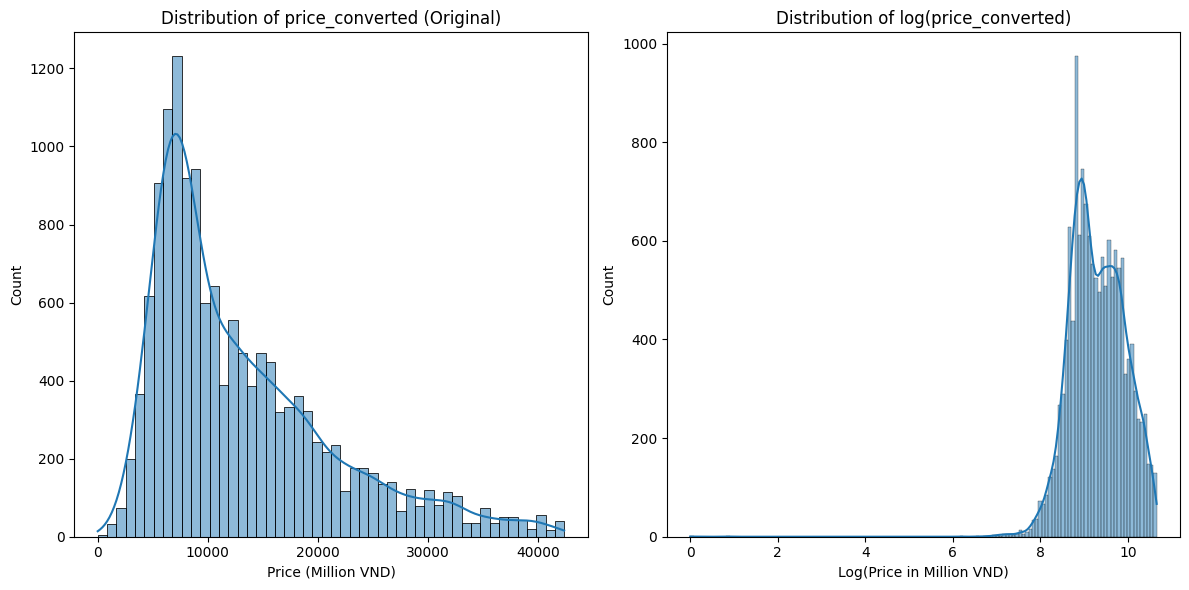

Original price_converted skewness: 1.2241
Log-transformed price_converted skewness: -0.4230


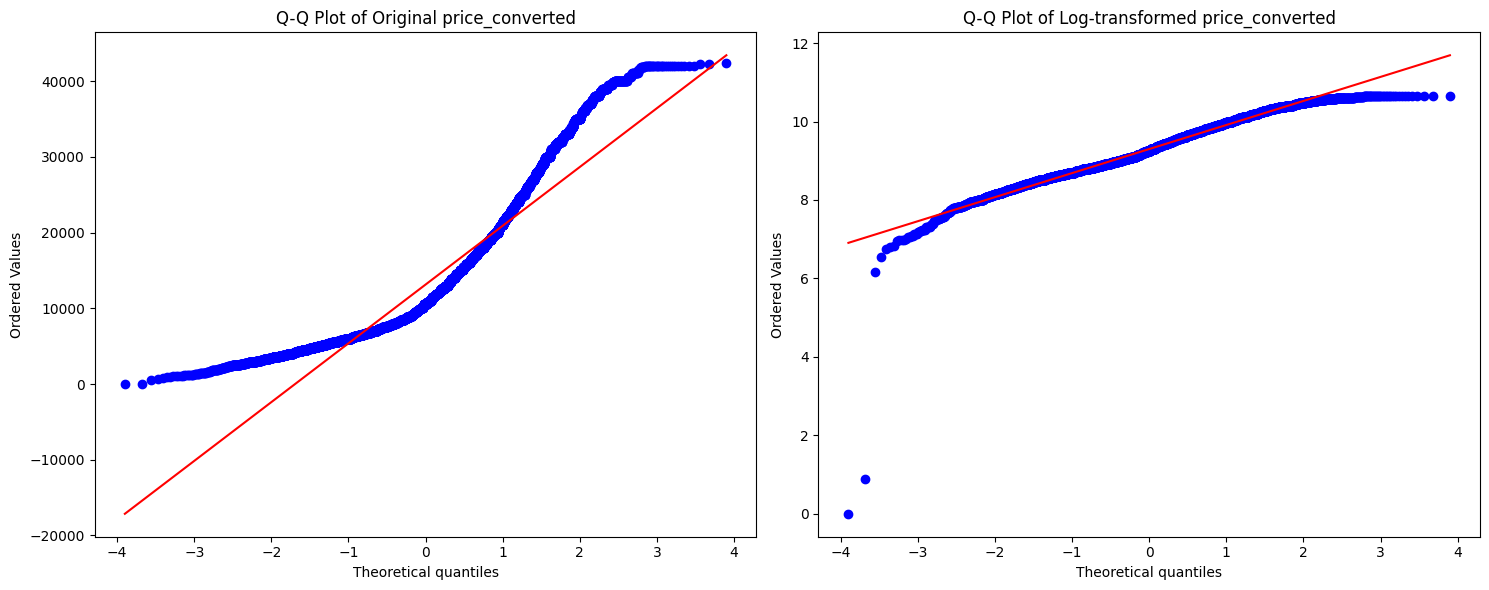

In [4]:
# Analyze the price_converted distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['price_converted'], kde=True)
plt.title('Distribution of price_converted (Original)')
plt.xlabel('Price (Million VND)')

# Create log-transformed version of price_converted for better distribution
df['price_converted_log'] = np.log1p(df['price_converted'])

plt.subplot(1, 2, 2)
sns.histplot(df['price_converted_log'], kde=True)
plt.title('Distribution of log(price_converted)')
plt.xlabel('Log(Price in Million VND)')

plt.tight_layout()
plt.show()

# Calculate skewness to decide if log transformation is helpful
original_skew = stats.skew(df['price_converted'].dropna())
log_skew = stats.skew(df['price_converted_log'].dropna())
print(f"Original price_converted skewness: {original_skew:.4f}")
print(f"Log-transformed price_converted skewness: {log_skew:.4f}")

# Create a QQ plot to check normality of both distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
stats.probplot(df['price_converted'].dropna(), plot=ax1)
ax1.set_title('Q-Q Plot of Original price_converted')

stats.probplot(df['price_converted_log'].dropna(), plot=ax2)
ax2.set_title('Q-Q Plot of Log-transformed price_converted')

plt.tight_layout()
plt.show()

## 4. Feature Engineering and Selection

We'll create enhanced features for our model predicting the absolute price (`price_converted`).

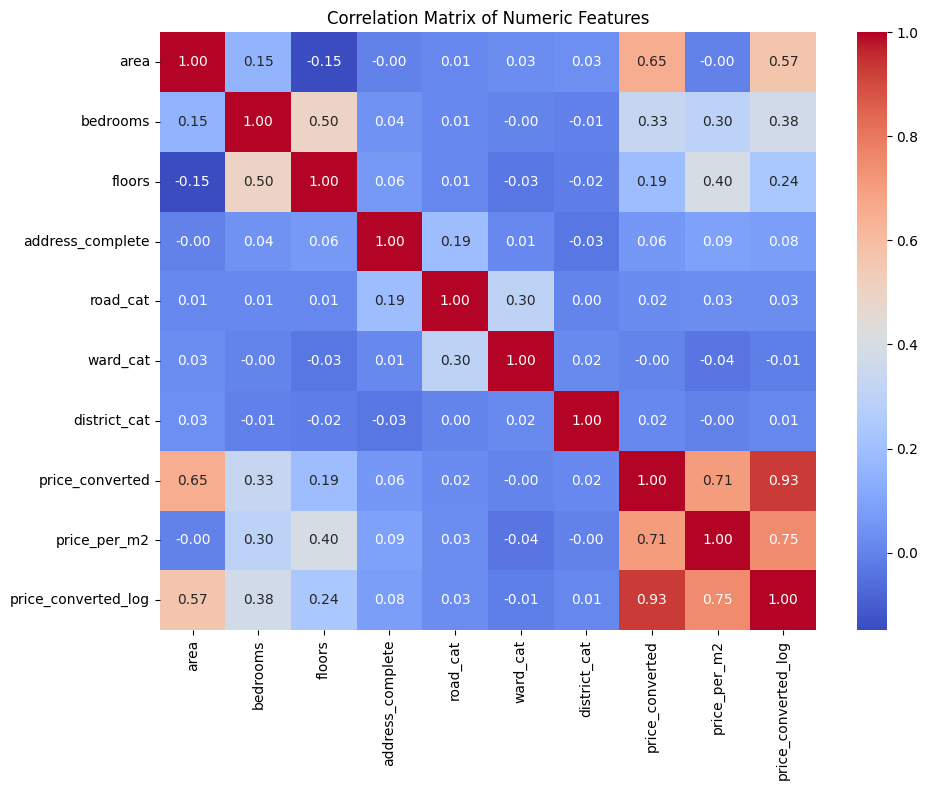

Correlations with price_converted:
price_converted        1.00
price_converted_log    0.93
price_per_m2           0.71
area                   0.65
bedrooms               0.33
floors                 0.19
address_complete       0.06
road_cat               0.02
district_cat           0.02
ward_cat              -0.00
Name: price_converted, dtype: float64


In [5]:
# Examine correlations with price_converted to inform feature selection
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# Print correlations with price_converted
price_correlations = correlation_matrix['price_converted'].sort_values(ascending=False)
print("Correlations with price_converted:")
print(price_correlations)

Feature set shape: (14426, 10)
Target shape: (14426,)

Feature set sample:


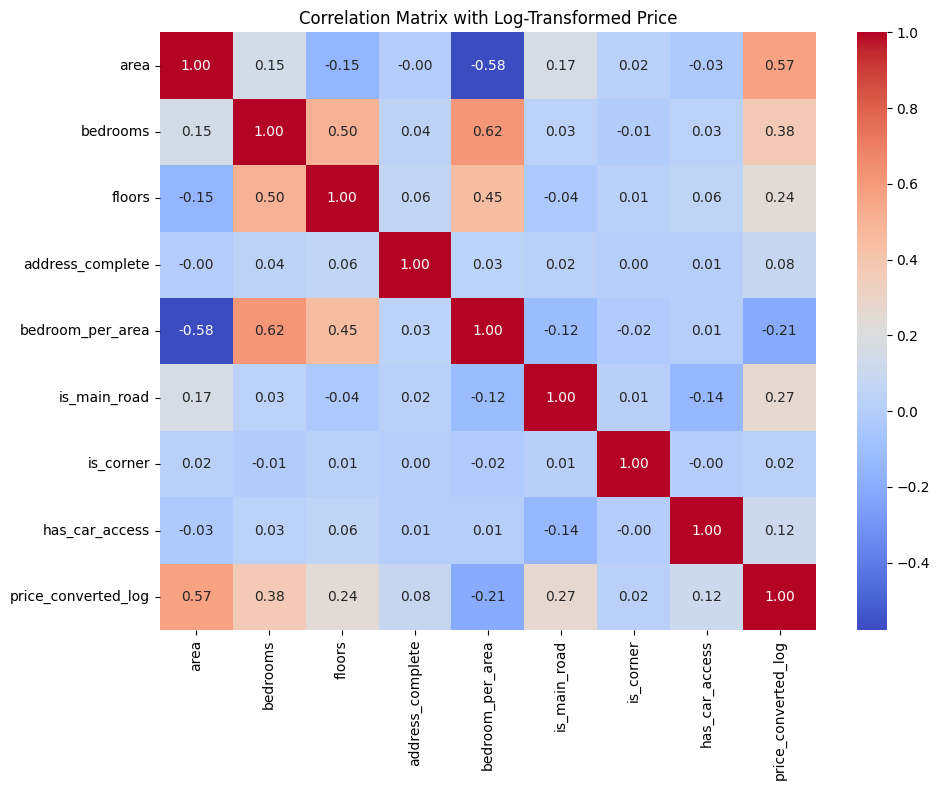


Top correlations with log-transformed price_converted:
price_converted_log    1.00
area                   0.57
bedrooms               0.38
is_main_road           0.27
floors                 0.24
has_car_access         0.12
address_complete       0.08
is_corner              0.02
bedroom_per_area      -0.21
Name: price_converted_log, dtype: float64


In [6]:
# Enhanced feature engineering based on EDA insights
# Create derived features to capture more complex relationships

# Create bedroom density feature
df['bedroom_per_area'] = df['bedrooms'] / df['area']

# Extract property characteristics from title using regex
df['is_corner'] = df['title'].str.contains('GÓC|GÓCH?', case=False, regex=True).astype(int)
df['is_main_road'] = df['title'].str.contains('MẶT PHỐ|MẶT TIỀN|MẶT ĐƯỜNG', case=False, regex=True).astype(int)
df['has_car_access'] = df['title'].str.contains('Ô TÔ|OTO|XE HƠI', case=False, regex=True).astype(int)

# Create district price categories based on median prices
district_price = df.groupby('district')['price_converted'].median().sort_values()
price_percentiles = np.percentile(district_price, [33, 66])
price_labels = ['low_price', 'mid_price', 'high_price']
district_price_category = pd.cut(district_price, 
                                bins=[0] + list(price_percentiles) + [float('inf')], 
                                labels=price_labels)
district_to_price_category = dict(zip(district_price.index, district_price_category))
df['district_price_category'] = df['district'].map(district_to_price_category)

# Select expanded feature set - including area as a key feature for absolute price prediction
numeric_features = ['area', 'bedrooms', 'floors', 'address_complete', 'bedroom_per_area', 
                   'is_main_road', 'is_corner', 'has_car_access']

# Expanded categorical features
categorical_features = ['district', 'district_price_category']

# Define features and target (using price_converted instead of price_per_m2)
X = df[numeric_features + categorical_features].copy()
y = df['price_converted']
y_log = df['price_converted_log']

print("Feature set shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature set sample:")
X.head()

# Visualize correlation with log-transformed target variable
plt.figure(figsize=(10, 8))
# Ensure only numeric columns are used for correlation
numeric_df = X.select_dtypes(include=np.number)
corr_data = pd.concat([numeric_df, y_log], axis=1)
correlation_matrix = corr_data.corr()

# Plot correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Log-Transformed Price')
plt.tight_layout()
plt.show()

# Display top correlations with price_converted_log
price_correlations = correlation_matrix['price_converted_log'].sort_values(ascending=False)
print("\nTop correlations with log-transformed price_converted:")
print(price_correlations)

## 5. Data Preprocessing Pipeline

We'll create a preprocessing pipeline similar to the one used for the previous models:
1. Standard scaling for numeric features
2. One-hot encoding for categorical features

In [7]:
# Create preprocessing pipelines with robust transformers for price prediction
numeric_transformer = Pipeline(steps=[
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),  # Better handles skewed features
    ('scaler', RobustScaler())  # Less sensitive to outliers than StandardScaler
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Display the preprocessing pipeline
print("Preprocessing Pipeline:")
print(preprocessor)

Preprocessing Pipeline:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('power',
                                                  PowerTransformer(standardize=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['area', 'bedrooms', 'floors',
                                  'address_complete', 'bedroom_per_area',
                                  'is_main_road', 'is_corner',
                                  'has_car_access']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['district', 'district_price_category'])])


## 6. Split Data and Train Random Forest Model

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (11540, 10)
Testing set shape: (2886, 10)


## 7. Hyperparameter Tuning with GridSearchCV

We'll tune the following hyperparameters for the Random Forest regressor:
1. n_estimators: The number of trees in the forest
2. max_depth: The maximum depth of the trees
3. min_samples_split: The minimum number of samples required to split an internal node
4. min_samples_leaf: The minimum number of samples required to be at a leaf node

In [9]:
# Create the Random Forest pipeline with preprocessing
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 300],  # Expanded n_estimators
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', 0.7]  # Added max_features
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV to find optimal parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)  # Convert back to RMSE

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation RMSE: {best_score:.2f} million VND/m²")

# Create the best Random Forest model
best_rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=best_params['regressor__n_estimators'],
        max_depth=best_params['regressor__max_depth'],
        min_samples_split=best_params['regressor__min_samples_split'],
        min_samples_leaf=best_params['regressor__min_samples_leaf'],
        max_features=best_params['regressor__max_features'], # Ensure this is used
        random_state=42
    ))
])

# Train the best model
best_rf_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best Parameters: {'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 300}
Best Cross-Validation RMSE: 4513.53 million VND/m²


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer(standardize=False)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['area', 'bedrooms', 'floors',
                                                   'address_complete',
                                                   'bedroom_per_area',
                                                   'is_main_road', 'is_corner',
                                                   'has_car_access']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['district',
                                                   'district_price_category'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, max_features='sqrt',
                                       min_samples_split=10, n_estimators=300,
                                       random_state=42))])

## 8. Model Evaluation

In [10]:
# Make predictions
y_train_pred = best_rf_pipeline.predict(X_train)
y_test_pred = best_rf_pipeline.predict(X_test)

# Evaluate the model
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Random Forest Regression Model Performance:")
print(f"Training R² Score: {train_r2:.4f}")
print(f"Testing R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f} million VND/m²")
print(f"Testing RMSE: {test_rmse:.2f} million VND/m²")
print(f"Training MAE: {train_mae:.2f} million VND/m²")
print(f"Testing MAE: {test_mae:.2f} million VND/m²")

Random Forest Regression Model Performance:
Training R² Score: 0.8235
Testing R² Score: 0.7121
Training RMSE: 3472.61 million VND/m²
Testing RMSE: 4382.96 million VND/m²
Training MAE: 2453.10 million VND/m²
Testing MAE: 3033.93 million VND/m²


## 9. Visualize Results

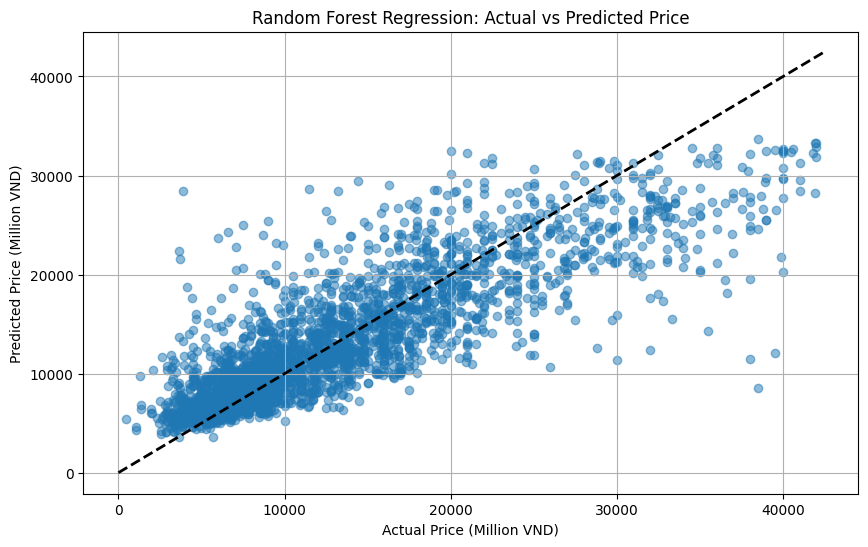

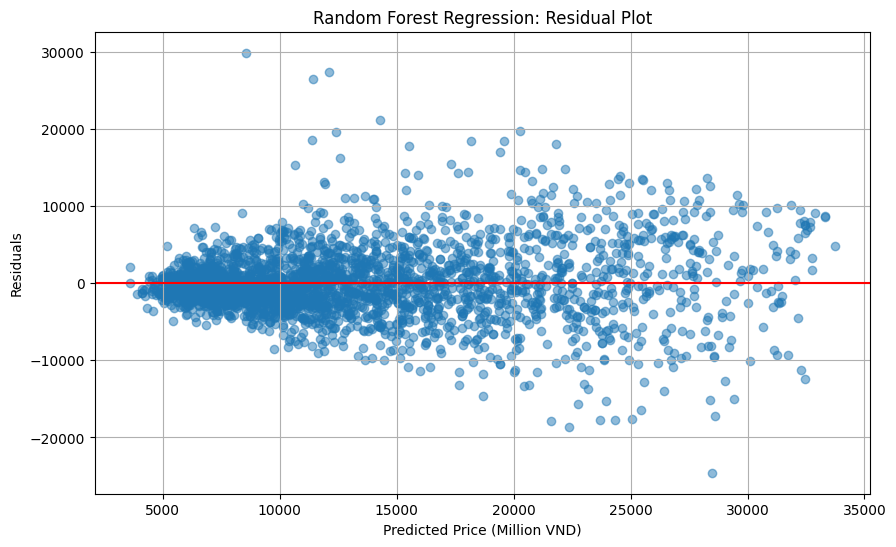

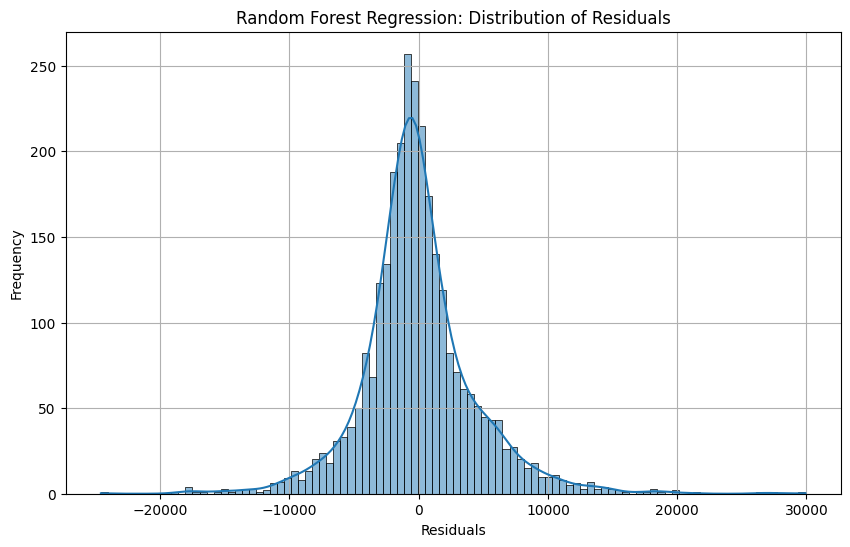

In [11]:
# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price (Million VND)')
plt.ylabel('Predicted Price (Million VND)')
plt.title('Random Forest Regression: Actual vs Predicted Price')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Price (Million VND)')
plt.ylabel('Residuals')
plt.title('Random Forest Regression: Residual Plot')
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Random Forest Regression: Distribution of Residuals')
plt.grid(True)
plt.show()

## 10. Feature Importance Analysis

One of the advantages of Random Forest is that it provides a measure of feature importance. Let's look at which features have the most impact on our predictions.

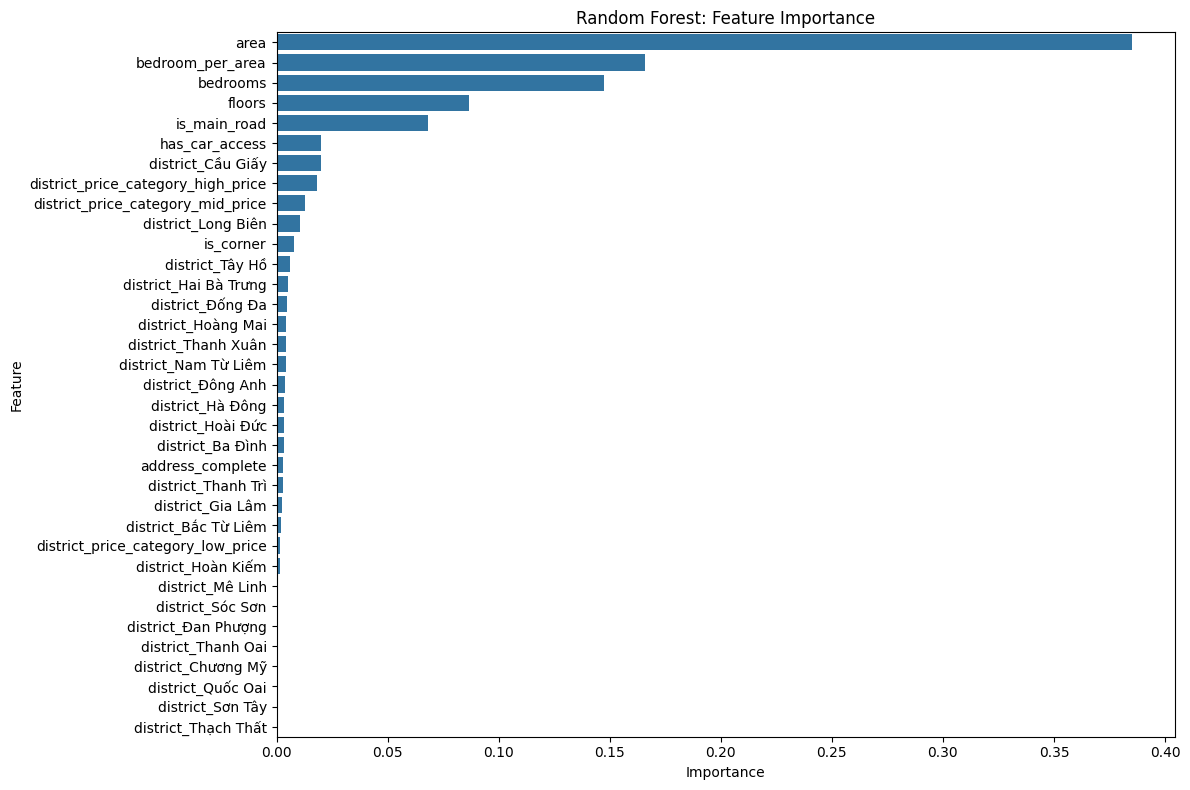

Top 10 Most Important Features:
area                                 0.39
bedroom_per_area                     0.17
bedrooms                             0.15
floors                               0.09
is_main_road                         0.07
has_car_access                       0.02
district_Cầu Giấy                    0.02
district_price_category_high_price   0.02
district_price_category_mid_price    0.01
district_Long Biên                   0.01
dtype: float64


In [12]:
# Get feature names from the preprocessor
ohe_feature_names = best_rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(ohe_feature_names)

# Get feature importances
importances = best_rf_pipeline.named_steps['regressor'].feature_importances_

# Create a pandas Series for better visualization
feature_importance = pd.Series(importances, index=feature_names)
feature_importance = feature_importance.sort_values(ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Random Forest: Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the top 10 most important features
print("Top 10 Most Important Features:")
print(feature_importance.head(10))